![](./datasets/properati.png)
# Análisis exploratorio de datos - Properati

**Alumnos:**
* Cabrera, Laura - 87696
* Mankowski, Daniel - 84658
* Rivas, Rafael
* Rocha, Santiago - 85726

**Link al repo en github:** https://github.com/DanielMankowski/Data-Scients

In [125]:
%matplotlib inline

import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('default') # haciendo los graficos un poco mas bonitos xD
plt.rcParams['figure.figsize'] = (15, 5)

In [126]:
# Levantamos los datos obtenidos de Properati
propiedades = pd.read_csv('./datasets/properati-AR-2017-08-01-properties-sell.csv',sep=',',error_bad_lines=False,low_memory=False)
propiedades.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187482 entries, 0 to 187481
Data columns (total 27 columns):
id                            187482 non-null object
created_on                    187482 non-null object
operation                     187482 non-null object
property_type                 187482 non-null object
place_name                    187447 non-null object
place_with_parent_names       187482 non-null object
country_name                  187482 non-null object
state_name                    187482 non-null object
geonames_id                   158318 non-null float64
lat-lon                       118761 non-null object
lat                           118761 non-null float64
lon                           118761 non-null float64
price                         154443 non-null float64
currency                      154441 non-null object
price_aprox_local_currency    154443 non-null float64
price_aprox_usd               154443 non-null float64
surface_total_in_m2           12502

In [127]:
# Vemos un registro como ejemplo del dataframe
propiedades.sample()

,id,created_on,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
130779,ec34f5ac372863293613acc32522bfa882e287e8,2017-07-19,sell,store,Beccar,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro...,Argentina,Bs.As. G.B.A. Zona Norte,3436080,NaN,...,314,NaN,1496.815287,NaN,NaN,NaN,http://www.properati.com.ar/1ab58_venta_local_...,"Sobre Av. Rolón a metros de José Ingenieros, L...",Edificio Comercial - Beccar Alto,https://thumbs4.properati.com/3/QrSRDRFoueuDMd...


### Data Cleaning
* Analizar los diferentes valores que puede tomar state_name para hacer el filtro correctamente y no perder información.

In [128]:
propiedades.loc[:, 'state_name'].value_counts()

Capital Federal                 44152
Bs.As. G.B.A. Zona Norte        39888
Bs.As. G.B.A. Zona Oeste        22571
Buenos Aires Costa Atlántica    20694
Bs.As. G.B.A. Zona Sur          18135
Córdoba                         15777
Santa Fe                        13516
Buenos Aires Interior            4686
Río Negro                        1152
Neuquén                          1057
Mendoza                           927
Misiones                          817
Entre Ríos                        793
Tucumán                           715
Corrientes                        629
San Luis                          444
Salta                             372
Chubut                            329
La Pampa                          301
Catamarca                         126
Chaco                              95
San Juan                           86
Tierra Del Fuego                   69
Formosa                            66
Santa Cruz                         40
Jujuy                              32
La Rioja    

* Agregar columnas de Año y Mes para futuros análisis

In [129]:
propiedades.loc[:,'year'] = pd.to_datetime(propiedades.loc[:,'created_on']).dt.year
propiedades.loc[:,'month'] = pd.to_datetime(propiedades.loc[:,'created_on']).dt.month
propiedades.sample()

,id,created_on,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,...,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,year,month
79661,db5090607fa3c71a75efdc17a6d0ea83cafd4921,2017-03-20,sell,apartment,Mar del Plata,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,3430863,"-38.005795,-57.5449849",...,NaN,NaN,3,NaN,http://www.properati.com.ar/16ple_venta_depart...,"Departamento 3 ambientes, Buenos Aires Costa A...",VENTA DEPARTAMENTO,https://thumbs4.properati.com/1/j5FLVUY_vReDqG...,2017,3


* Filtrar las propiedades de CABA y GBA.

In [130]:
# Como el enunciado lo indica nos quedamos con los datos de Capital Federal y Gran Buenos Aires
prop_caba_gba = propiedades[propiedades['state_name'].str.contains('Capital Federal') | \
                            propiedades['state_name'].str.contains('G.B.A.')]
prop_caba_gba.sample()

,id,created_on,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,...,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,year,month
81861,e47bf51517f0f3a404b04a86d6018927f9852e27,2017-03-28,sell,house,Nordelta,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Nord...,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.4354185946,-58.6436058174",...,2018.43318,NaN,NaN,NaN,http://www.properati.com.ar/16wei_venta_casa_n...,Casa en Nordelta en venta Castaños.Ubicada en ...,Casa en Nordelta en venta Castaños,https://thumbs4.properati.com/8/sGZpy8pPlC95Hm...,2017,3


* Agregar una columna con el Barrio o Partido de la propiedad 

In [131]:
def parsear_zona(row):
    mylist = row.loc['place_with_parent_names'].split("|")
    return mylist[3]

prop_caba_gba.loc[:,'neighborhood'] = prop_caba_gba.apply(parsear_zona, axis=1)   

In [132]:
# Vista final de cómo quedó el DataFrame
prop_caba_gba.head()

,id,created_on,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,...,floor,rooms,expenses,properati_url,description,title,image_thumbnail,year,month,neighborhood
0,c8a66ee9e3da083ab66dacd165e8a5cc718b1cf2,2012-09-19,sell,house,San Antonio De Padua,|Argentina|Bs.As. G.B.A. Zona Oeste|Merlo|San ...,Argentina,Bs.As. G.B.A. Zona Oeste,3429244,NaN,...,NaN,NaN,NaN,http://www.properati.com.ar/udh_venta_casa_mer...,CASA CON LOCAL EN VENTA EN PADUA.2 DORMITORIOS...,CASA EN VENTA,https://thumbs4.properati.com/1/ufoyqwscVk8n3e...,2012,9,Merlo
1,a205c53378e7879cf7519659317fb410c060d20e,2012-10-22,sell,house,San Antonio De Padua,|Argentina|Bs.As. G.B.A. Zona Oeste|Merlo|San ...,Argentina,Bs.As. G.B.A. Zona Oeste,3429244,NaN,...,NaN,NaN,NaN,http://www.properati.com.ar/20hi_venta_casa_me...,CHALET VENTA 4 AMBIENTES PADUA.EXCELENTE CHALE...,CASA EN VENTA,https://thumbs4.properati.com/5/I5RS_jAIUseo9H...,2012,10,Merlo
4,9446052c949050359fb08b9f1ba83ba2eaa20c99,2012-12-08,sell,house,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787,"-34.6544492346,-58.4895603251",...,NaN,5,NaN,http://www.properati.com.ar/4m4m_venta_casa_ma...,Casa Multifamiliar en Mataderos!!! Sobre lote ...,CASA EN VENTA,https://thumbs4.properati.com/6/DsNJjCb5_zIPV0...,2012,12,Mataderos
5,4d3b492ed5f9c74cdf33b56b98328e5c950e3f9c,2013-01-04,sell,apartment,Pilar,|Argentina|Bs.As. G.B.A. Zona Norte|Pilar|,Argentina,Bs.As. G.B.A. Zona Norte,3429979,"-34.429071,-58.795418",...,NaN,2,NaN,http://www.properati.com.ar/518a_venta_departa...,"Venta - Departamento - Argentina, Buenos Aires...",Departamento en Venta ubicado en Arcos de Pilar,https://thumbs4.properati.com/8/bJn9FqcBRGi_8H...,2013,1,Pilar
6,535441f569473f6e5d687c38b27d9b9c6e69e284,2013-01-09,sell,store,San Isidro,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro|,Argentina,Bs.As. G.B.A. Zona Norte,3428983,"-34.4789383,-58.5214371",...,NaN,1,NaN,http://www.properati.com.ar/52p4_venta_local_s...,"Venta - Local - Argentina, Buenos Aires, Zona ...",Local en Venta ubicado en San Isidro,https://thumbs4.properati.com/9/ZCK2RkrsymyN5s...,2013,1,San Isidro


## ¿Cuántas propiedades se vendieron por estado?

Entendemos como **Estado** a Capital Federal o cada una de las 3 regiones del Gran Buenos Aires. Una primera vista nos permite tener una idea de cómo se dividió la cantidad de ventas de propiedades entre estos cuatro estados.

In [133]:
prop_barrio = prop_caba_gba['state_name'].value_counts()
prop_barrio

Capital Federal             44152
Bs.As. G.B.A. Zona Norte    39888
Bs.As. G.B.A. Zona Oeste    22571
Bs.As. G.B.A. Zona Sur      18135
Name: state_name, dtype: int64

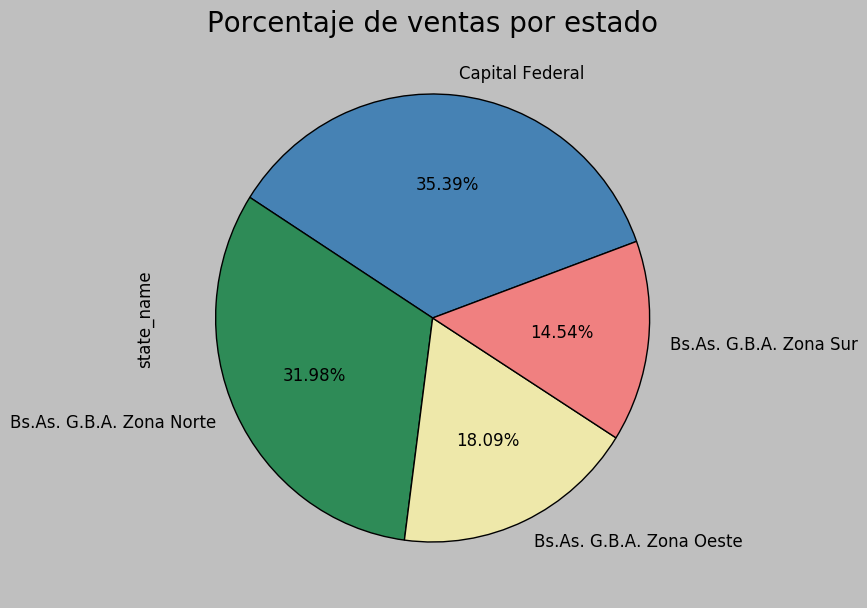

In [134]:
plt.figure()
colors = ['steelblue', 'seagreen', 'palegoldenrod', 'lightcoral']
plt.title('Porcentaje de ventas por estado', fontsize=20)
prop_barrio.plot.pie(figsize=(7, 7), colors = colors, autopct='%1.2f%%', startangle=20);


Podemos observar que la mayoría de las ventas se producen en CABA en su totalidad y la Zona Norte del Gran Buenos Aires.

### ¿Cuáles son los barrio en donde se produce el mayor número de ventas?

Queremos hacer un análisis más fino sobre la distribución de ventas ya no por estados sino por barrios; entendiendo por **barrio** a un barrio de CABA propiamente dicho o una localidad del Gran Buenos Aires. Para esto vamos a usar la columna *neighborhood* que obtuvimos previamente.

In [135]:
prop_localidad = prop_caba_gba['neighborhood'].value_counts().head(10)
prop_localidad

Tigre              13594
La Matanza          7947
Morón               5926
Palermo             5383
Vicente López       5218
San Isidro          5011
Pilar               4701
La Plata            4326
Lomas de Zamora     3828
Belgrano            3796
Name: neighborhood, dtype: int64

Si bien en el anĺisis previo la mayoría de las ventas se realiza en CABA, al hacer este segundo análisis más detallado nos encontramos que es la localidad de **Tigre** la que concentra el mayor número de transacciones.

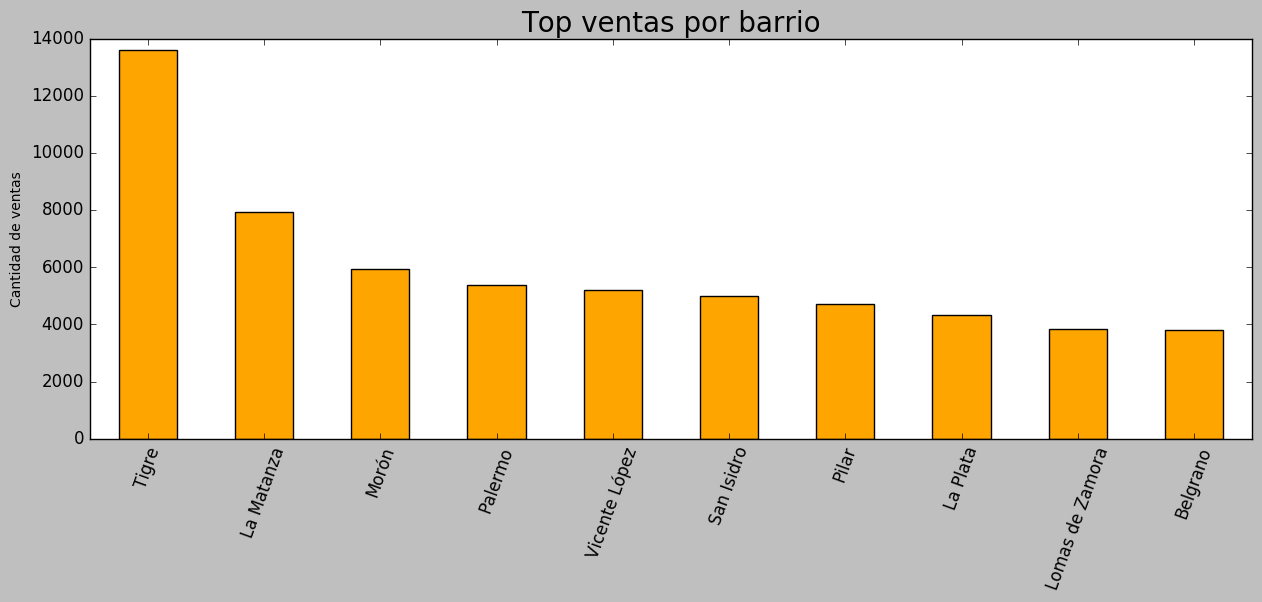

In [136]:
plt.title('Top ventas por barrio', fontsize=20)
plt.ylabel('Cantidad de ventas', fontsize=10)
prop_localidad.plot('bar', rot=70, color='orange')

## ¿Cuántas propiedades de cada tipo se venden?

Nos interesa analizar si hay varios tipos de propiedad a la ventas y cuántos operaciones se concretan. Esto podría ayudarnos a predecir si existe algún tipo de preferencia a la hora de buscar una propiedad o el perfil del usuario.

In [137]:
prop_caba_gba['property_type'].value_counts()

apartment    68826
house        44258
PH            7045
store         4617
Name: property_type, dtype: int64

Según los datos obtenidos, se puede observar que la gran mayoría de las publicaciones son sobre Departamentos o Casas, quedando muy por detrás los PH y los comercios.

## ¿Influye el barrio en el valor de las propiedades?

Queremos ver el valor promedio de las propiedades en relación al barrio al cual pertenecen. Para no tener valores distorsionados filtramos los barrios que tengan menos de 50 ventas.

In [138]:
data = prop_caba_gba.loc[:,['neighborhood', 'price_aprox_usd']]
data = data[data['neighborhood'] <> '']
group_by_barrio = data.groupby('neighborhood').agg([np.mean, np.size])
group_by_barrio = group_by_barrio.loc[group_by_barrio[('price_aprox_usd','size')] > 50]\
                  .sort_values(('price_aprox_usd','mean'), ascending=False)
group_by_barrio.head(10)

price_aprox_usd       
                             mean   size
neighborhood                            
Puerto Madero       933102.405806   1146
San Isidro          453277.572763   5011
Recoleta            451190.720953   2068
Retiro              395079.866257    393
Tigre               381874.766485  13594
Belgrano            378185.525543   3796
Palermo             372118.074596   5383
Nuñez               370172.824995   1009
General Rodríguez   364753.685656    265
Las Cañitas         348438.882353    226

In [139]:
data_barrio = prop_caba_gba.loc[:,['place_name', 'price_aprox_usd']]
data_barrio.dropna(inplace=True)
group_by_place = data_barrio.groupby('place_name').agg([np.mean, np.size])
group_by_place = group_by_place.loc[group_by_place[('price_aprox_usd','size')] > 50]\
                 .sort_values(('price_aprox_usd','mean'), ascending=False)
group_by_place.head(10)

price_aprox_usd      
                                        mean  size
place_name                                        
Palermo Chico                 1084513.340741   270
Puerto Madero                  933102.405806  1030
Santa Barbara Barrio Cerrado   781538.260870   115
Acassuso                       710082.134571   431
Barrio Los Lagos               615116.129032    62
Mayling Club de Campo          542988.764045    89
Martínez                       472497.768105  1689
Capital Federal                464895.209311  1800
Recoleta                       451190.720953  1889
Vicente López                  449455.756631   929

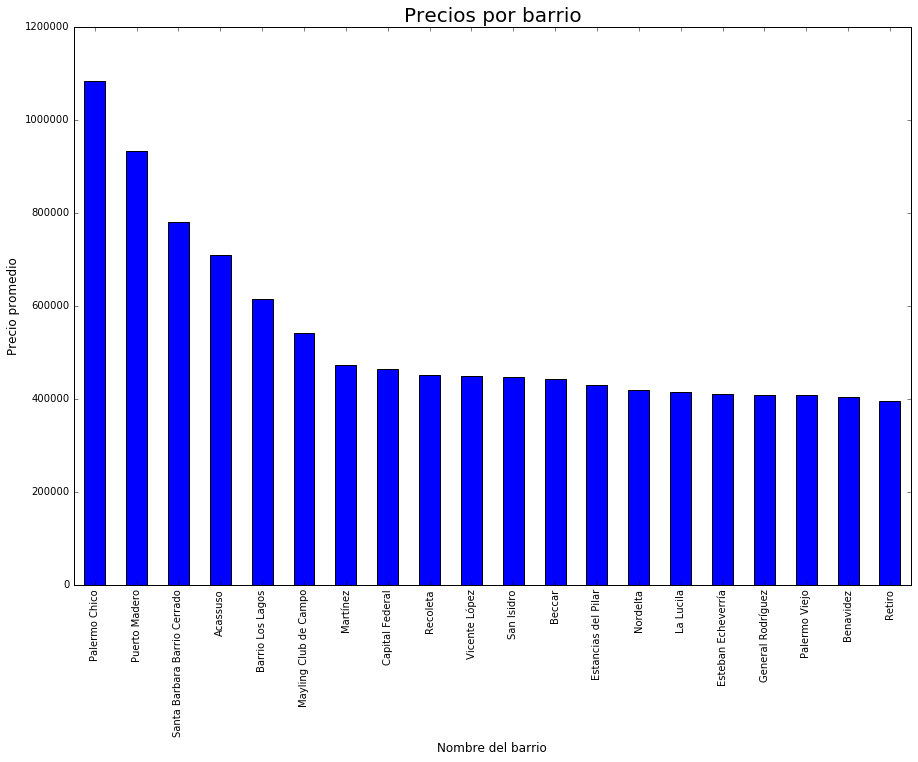

In [140]:
%matplotlib inline
pl = group_by_place.loc[:,('price_aprox_usd','mean')].head(20).plot('bar', title = 'Precios por barrio', figsize=(15,10))
pl.set_xlabel('Nombre del barrio', fontsize = 12)
pl.set_ylabel('Precio promedio', fontsize = 12)
pl.set_title('Precios por barrio', fontsize = 20);

Podemos observar que los valores calculados se condicen con lo que uno pensaria, ya que vemos a Palermo y Puerto Madero en los primeros puestos. Luego se ven algunos barrios cerrados en la lista seguramente porque es un negocio particular de la inmobiliaria y tienen una muestra considerable.

### Cantidad de ventas de propiedades por año y mes

In [141]:
ventas_por_anio = prop_caba_gba.groupby('year').count()['created_on']
ventas_por_anio

year
2012        3
2013      417
2014     4348
2015    10208
2016    24730
2017    85040
Name: created_on, dtype: int64

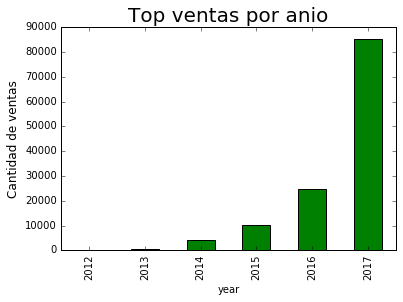

In [142]:
plt.title('Top ventas por anio', fontsize=20)
plt.ylabel('Cantidad de ventas', fontsize=12)
ventas_por_anio.plot('bar', color = 'green');

In [143]:
ventas_por_mes = prop_caba_gba.groupby(['year', 'month']).count()['created_on']

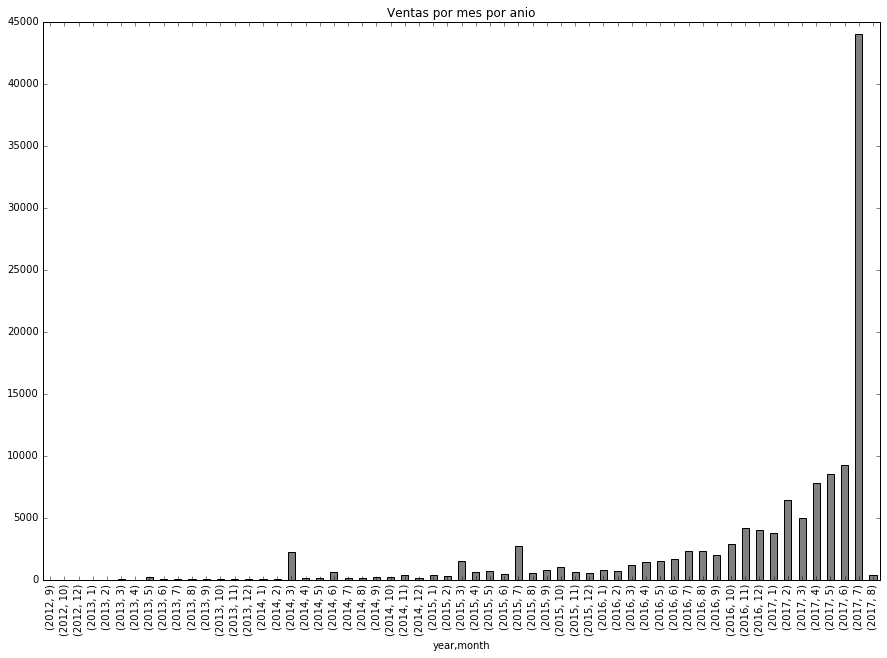

In [144]:
%matplotlib inline
ventas_por_mes.plot('bar', title = 'Ventas por mes por anio', figsize=(15,10), color = 'grey');

### Tipos de propiedad vendidas

In [145]:
ventas_por_tipo = prop_caba_gba.groupby(['year','property_type']).count()['created_on']

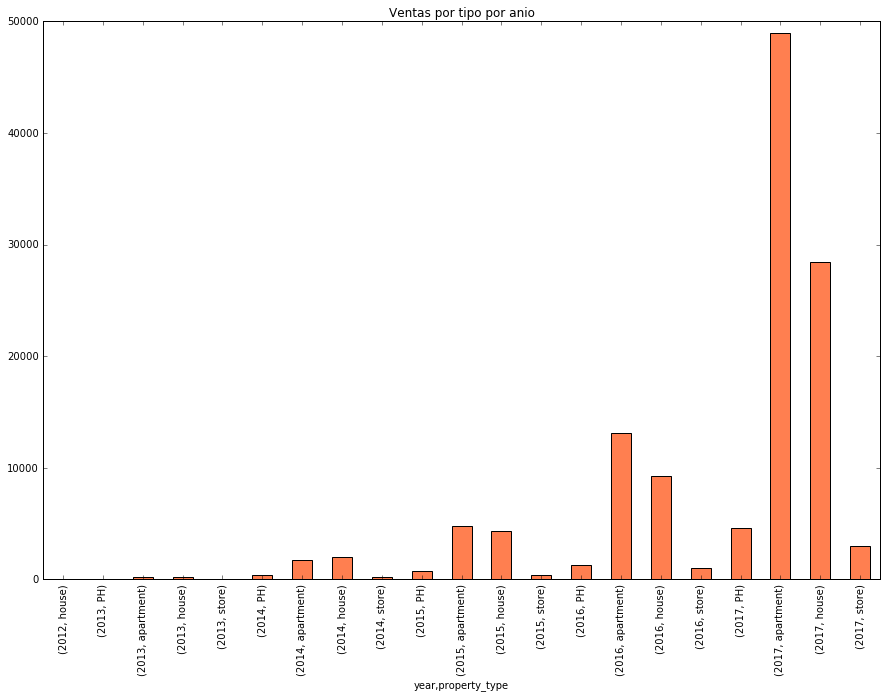

In [146]:
%matplotlib inline
ventas_por_tipo.plot('bar', title = 'Ventas por tipo por anio', figsize=(15,10), color= 'coral');

Podemos observar que en los ultimos años hubo un crecimiento en la cantidad de apartamentos respecto a las casas, esto podemos atribuirlo a diversos factores como lo son: el aumento de la poblacion, el aumento del precio del m2 que lleva a la gente a comprar viviendas mas pequeñas, la necesidad de la gente de vivir cerca de determinados puntos de la ciudad, el aumento de desarrollos inmobiliarios del tipo torres/edificios, etc.

### Evolución de ventas de departamentos por año

In [147]:
ventas_dptos = prop_caba_gba[prop_caba_gba['property_type'] == 'apartment']
ventas_dptos = ventas_dptos.groupby(['year', 'month']).count()['created_on']

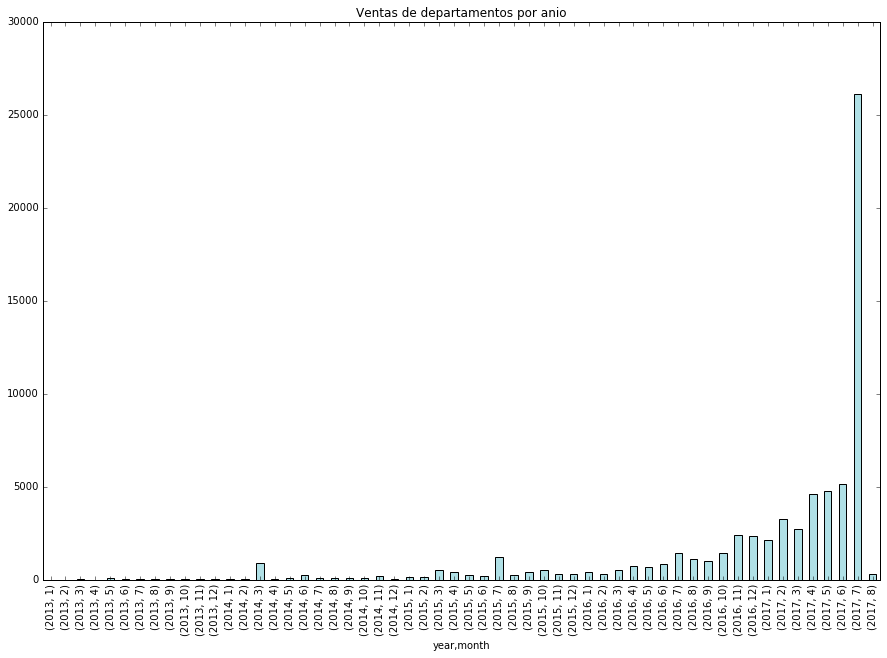

In [148]:
%matplotlib inline
ventas_dptos.plot('bar', title = 'Ventas de departamentos por anio', figsize=(15,10), color = 'powderblue');

# ¿Que pasa con Tigre y Zonas Aledañas?
En graficos anteriores hemos visto que en la base de datos proporcionada por Properati tenemos una gran cantidad de ventas/publicaciones en el partido de Tigre. Debido a que uno de los integrantes del grupo vive en dicho partido, hemos investigado un poco y descubierto que la zona ha crecido mucho en los ultimos 25 años. Si bien no tenemos datos sobre los ultimos 25 años, con la base de datos propuesta haremos un analisis de la evolucion del precio del m2 en dicha zona intentando de sacar alguna tendencia. Para el analisis nos hemos propuesto comparar la evolucion de 3 zonas de Tigre ( Nordelta, Benavidez, Tigre Centro ) y de San Fernando partido aledaño a Tigre y que tambien ha crecido mucho en los ultimos años como alternativa a Tigre.
Elegimos Nordelta ya que su crecimiento ha sido realmente exponencial y creemos que influye en el precio de zonas aledañas como es Tigre y Benavidez
Elegimos San Fernando ya que entendemos que en los ultimos años ha sido buscado como alternativa a Tigre para vivir en zona norte a buen precio.


In [149]:
# Nos quedamos con las propiedades de Tigre, San Fernando, Nordelta, Benavidez
# Debido a la poca cantidad de registros en 2012 y 2014 los excluiremos del analisis
prop_zn = prop_caba_gba[(( prop_caba_gba['place_name'] == 'Nordelta' ) | ( prop_caba_gba['place_name'] == 'Tigre' ) | \
                        ( prop_caba_gba['place_name'] == 'San Fernando' ) | ( prop_caba_gba['place_name'] == 'Benavidez' )) \
                        & ( prop_caba_gba['year'] > 2013 )]

# Nos quedamos con las columnas que nos interesan y borramos si tienen datos vacios
prop_zn = prop_zn[['place_name', 'price_usd_per_m2', 'year']]
prop_zn.dropna(inplace=True)

prop_zn['place_name'].value_counts()


Nordelta        3474
Tigre           3383
Benavidez       1346
San Fernando     760
Name: place_name, dtype: int64

In [150]:
# Vemos como se distribuyen los datos respecto a los años
prop_zn['year'].value_counts()

2017    5805
2016    2240
2015     847
2014      71
Name: year, dtype: int64

In [151]:
# Hacemos un describe para ver la distribucion de los datos y si tenemos que filtrar algunos valores grandes o pequeños
# para que no introduzcan ruido en nuestro analisis
print(prop_zn.describe())

       price_usd_per_m2         year
count       8963.000000  8963.000000
mean        1869.698972  2016.537320
std         2108.885774     0.696555
min            4.166667  2014.000000
25%          989.246380  2016.000000
50%         1791.666667  2017.000000
75%         2327.272727  2017.000000
max        69710.656934  2017.000000


In [152]:
# De la ejecucion anterior notamos que tanto el max como el minimo son valores poco probables para 
# el precio del m2 por lo que filtraremos utilazando como criterio la distribucion de los datos
prop_zn = prop_zn[(prop_zn['price_usd_per_m2'] > 300) & ( prop_zn['price_usd_per_m2'] < 10000 )]
print(prop_zn.describe())

       price_usd_per_m2         year
count       8647.000000  8647.000000
mean        1806.738795  2016.553949
std          969.005663     0.680057
min          301.387137  2014.000000
25%         1125.000000  2016.000000
50%         1820.833333  2017.000000
75%         2336.355932  2017.000000
max         9900.000000  2017.000000


### ¿Cual es la relacion entre precio prom del m2 entre Tigre y Nordelta?

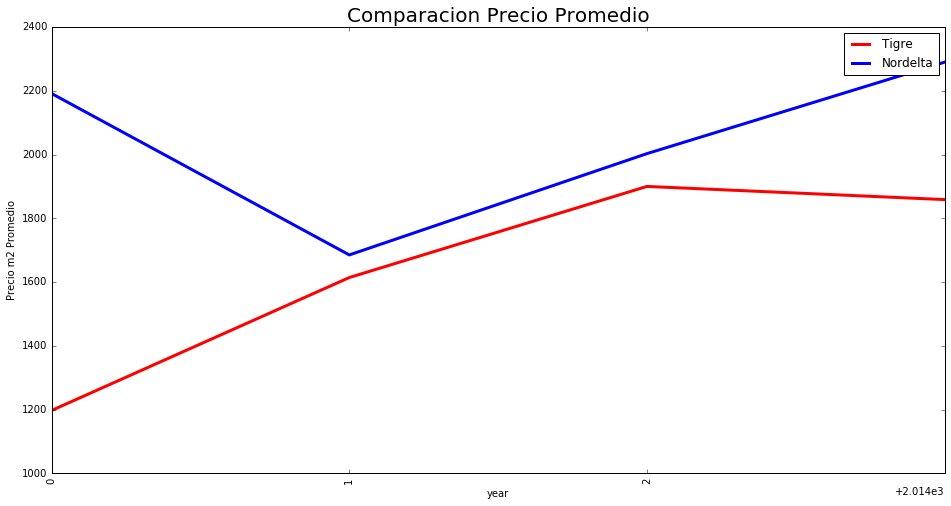

In [153]:
# Veamos la comparacion de precio promedio del metro cuadrado de Tigre vs San Fernando
%matplotlib inline
plt.figure()

plt.title('Comparacion Precio Promedio', fontsize=20)
plt.ylabel('Precio m2 Promedio', fontsize=10)
plt.xlabel('Anio', fontsize=10)
plt.grid(True)

prop_zn.loc[prop_zn['place_name'] == 'Tigre' , ['place_name' , 'price_usd_per_m2','year'] ]\
             .groupby('year').mean()\
             .loc[:,'price_usd_per_m2']\
             .plot.line(color='red',   rot=90, xticks=range(2014,2017), linewidth=3,figsize=(16,8), alpha=1,label='Tigre');
            
prop_zn.loc[prop_zn['place_name'] == 'Nordelta' , ['place_name' , 'price_usd_per_m2','year'] ]\
             .groupby('year').mean()\
             .loc[:,'price_usd_per_m2']\
             .plot.line(color='blue',   rot=90, xticks=range(2014,2017), linewidth=3,figsize=(16,8), alpha=1,label='Nordelta');            
            
plt.legend();  

Considerando que en 2014 no teniamos muchos datos y exluyendolo del analisis, podriamos decir que el precio de Nordelta y Tigre a ido creciendo en forma pareja a lo largo de los años. Es entendible debido a que ambas son zonas de auge en cuanto a ventas en zona norte debido a los desarrollos inmobiliarios que se han dado en los ultimos años. Otra de las razonas de la paridad puede deberse a que son zonas linderas y ambas pertenecen al partido de Tigre por lo que tambien puede haber algunas casas que figuren por ejemplo en place_name = Tigre pero pertenecen a Nordelta y Viceversa, por lo que podriamos tener un error en la carga de datos que nos afecta al analisis.

### Precio Promedio del M2 Tigre vs San Fernando

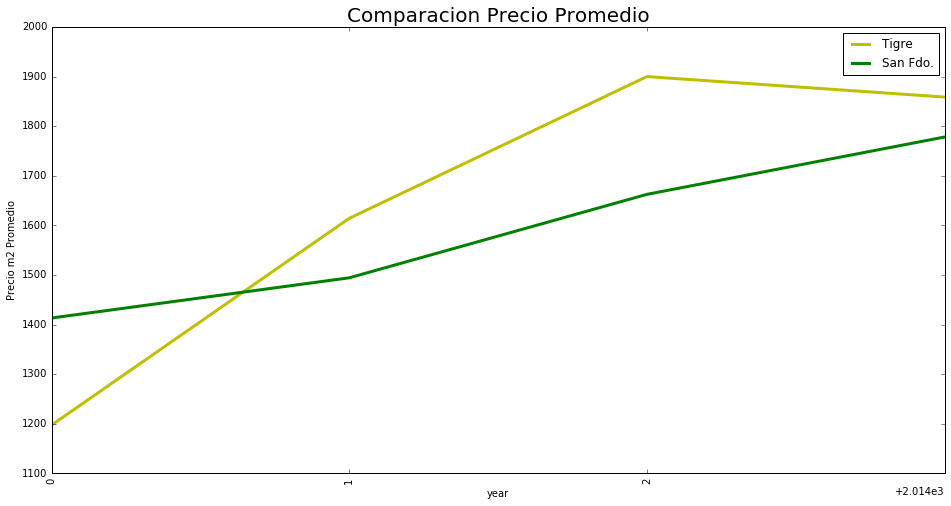

In [154]:
# Veamos la comparacion de precio promedio del metro cuadrado de Tigre vs San Fernando
%matplotlib inline
plt.figure()

plt.title('Comparacion Precio Promedio', fontsize=20)
plt.ylabel('Precio m2 Promedio', fontsize=10)
plt.xlabel('Anio', fontsize=10)
plt.grid(True)

prop_zn.loc[prop_zn['place_name'] == 'Tigre' , ['place_name' , 'price_usd_per_m2','year'] ]\
             .groupby('year').mean()\
             .loc[:,'price_usd_per_m2']\
             .plot.line(c='y',   rot=90, xticks=range(2014,2017), linewidth=3,figsize=(16,8), alpha=1,label='Tigre');
            
prop_zn.loc[prop_zn['place_name'] == 'San Fernando' , ['place_name' , 'price_usd_per_m2','year'] ]\
             .groupby('year').mean()\
             .loc[:,'price_usd_per_m2']\
             .plot.line(c='g',   rot=90, xticks=range(2014,2017), linewidth=3,figsize=(16,8), alpha=1,label='San Fdo.');            
            
plt.legend();            

Teniendo en cuenta que en 2014 teniamos pocos datos para poder sacar un buen promedio del precio del m2 vamos a analizar de 2015 a 2017. En dichos años podemos ver que Tigre tiene un precio por m2 superior a San Fernando dato que consideramos logico de acuerdo a lo que conocemos de Tigre como zona turistica. Podemos apreciar sin embargo que San Fernando a ido creciendo a lo largo de los años en cuanto a su precio promedio del m2 cuadrado al punto tal de achicar la brecha de precio que tenia con Tigre

### ¿Influyo el crecimiento del m2 en Nordelta en el precio del m2 en Benavidez?

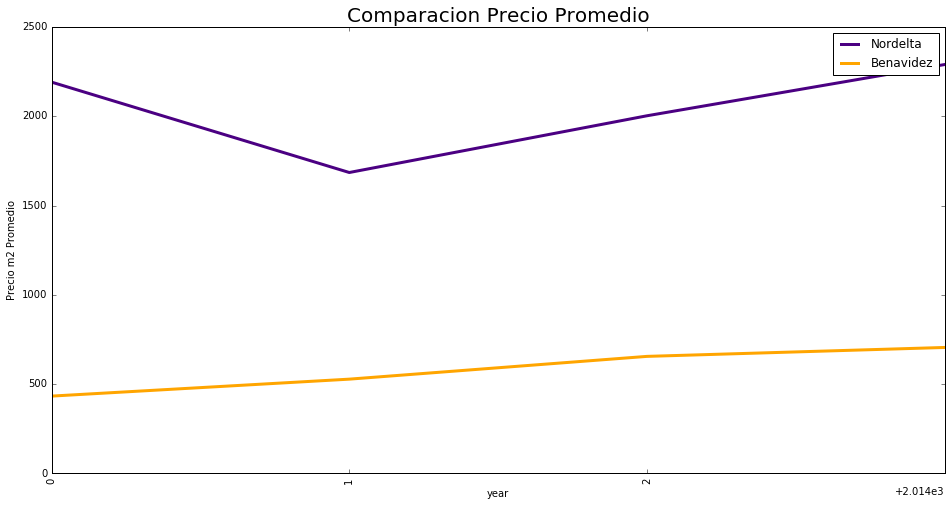

In [155]:
# Veamos la comparacion de precio promedio del metro cuadrado de Nordelta vs Benavidez
%matplotlib inline
plt.figure()


plt.title('Comparacion Precio Promedio', fontsize=20)
plt.ylabel('Precio m2 Promedio', fontsize=10)
plt.xlabel('Anio', fontsize=10)
plt.grid(True)

prop_zn.loc[prop_zn['place_name'] == 'Nordelta' , ['place_name' , 'price_usd_per_m2','year'] ]\
             .groupby('year').mean()\
             .loc[:,'price_usd_per_m2']\
             .plot.line(color='indigo',rot=90, xticks=range(2014,2017), linewidth=3,figsize=(16,8), alpha=1,label='Nordelta');
            
prop_zn.loc[prop_zn['place_name'] == 'Benavidez' , ['place_name' , 'price_usd_per_m2','year'] ]\
             .groupby('year').mean()\
             .loc[:,'price_usd_per_m2']\
             .plot.line(color='orange',rot=90, xticks=range(2014,2017), linewidth=3,figsize=(16,8), alpha=1,label='Benavidez');            
            
plt.legend();    

En este grafico podemos ver una gran diferencia en los precios por m2 de ambas zonas. Se nota que Benavidez tuvo un crecimiento en los ultimos años pero no logra achicar la brecha con Nordelta quien crece en manera mucho mayor. Es curioso este grafico ya que si bien Benavidez es un barrio mucho mas humilde que Nordelta, en los ultimos años se han desarrollado una gran cantidad de proyectos inmobiliarios en la zona lo que haria pensar que el precio por m2 deberia ser mucho mayor en promedio.

## Datos Adicionales para utilizar en los algoritmos

Para usar en el futuro con los algoritmos de predicción hicimos una búsqueda de datos adicionales que consideramos que pueden ser de utilidad. Por ejemplo una relación entre estaciones de subte/tren, escuelas, etc y el valor de las propiedades. Esto podría ser aplicado de forma relativamente sencilla con un algortimos de KNN luego de realizar un pre procesamiento de los datos.
Los datos fueron obtenidos de la pagina: https://data.buenosaires.gob.ar/

## Comunas

In [156]:
# Dataset con las comunas que pertencen a CABA
comunas = pd.read_csv('datasets/comunas.csv', sep=',', error_bad_lines=False, low_memory=False)
comunas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15 entries, 0 to 14
Data columns (total 5 columns):
WKT          15 non-null object
BARRIOS      15 non-null object
PERIMETRO    15 non-null float64
AREA         15 non-null float64
COMUNAS      15 non-null int64
dtypes: float64(2), int64(1), object(2)
memory usage: 720.0+ bytes


In [157]:
comunas

,WKT,BARRIOS,PERIMETRO,AREA,COMUNAS
0,MULTIPOLYGON (((-58.395205797051254 -34.572190...,RECOLETA,21246.611702,6140873.291133,2
1,MULTIPOLYGON (((-58.412870031308849 -34.614116...,ALMAGRO - BOEDO,12323.465538,6660526.190919,5
2,MULTIPOLYGON (((-58.430605828330876 -34.607047...,CABALLITO,10990.964471,6851028.913570,6
3,MULTIPOLYGON (((-58.451995245456509 -34.629745...,FLORES - PARQUE CHACABUCO,17972.257870,12422900.830800,7
4,MULTIPOLYGON (((-58.519254053232501 -34.633010...,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,16505305.786100,9
5,MULTIPOLYGON (((-58.488337367324576 -34.620160...,FLORESTA - MONTE CASTRO - VELEZ SARSFIELD - VE...,18332.037457,12656556.937800,10
6,MULTIPOLYGON (((-58.498384839883038 -34.596367...,VILLA DEL PARQUE - VILLA DEVOTO - VILLA GRAL....,19987.696155,14120042.423800,11
7,MULTIPOLYGON (((-58.503311325084404 -34.593856...,COGHLAN - SAAVEDRA - VILLA PUEYRREDON - VILLA ...,17232.189372,15570926.637600,12
8,MULTIPOLYGON (((-58.426759317276407 -34.552023...,PALERMO,21768.074886,15772496.331500,14
9,MULTIPOLYGON (((-58.41191880980378 -34.5980030...,BALVANERA - SAN CRISTOBAL,10486.260809,6385991.391502,3


## Subtes

In [158]:
# Dataset que nos proporciona informacion de todas las estaciones de subte
subtes = pd.read_csv('datasets/estaciones-de-subte.csv', sep=',', error_bad_lines=False, low_memory=False, encoding='latin1')
subtes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86 entries, 0 to 85
Data columns (total 5 columns):
X           86 non-null float64
Y           86 non-null float64
ID          86 non-null float64
ESTACION    86 non-null object
LINEA       86 non-null object
dtypes: float64(3), object(2)
memory usage: 4.0+ KB


In [159]:
subtes.head(10)

,X,Y,ID,ESTACION,LINEA
0,-58.398928,-34.635750,1,CASEROS,H
1,-58.400970,-34.629376,2,INCLAN,H
2,-58.402323,-34.623092,3,HUMBERTO 1°,H
3,-58.404732,-34.615242,4,VENEZUELA,H
4,-58.406036,-34.608935,5,ONCE - 30 DE DICIEMBRE,H
5,-58.380574,-34.604245,6,9 DE JULIO,D
6,-58.397924,-34.599757,7,FACULTAD DE MEDICINA,D
7,-58.385142,-34.601587,8,TRIBUNALES - TEATRO COLÓN,D
8,-58.407161,-34.591628,9,AGÜERO,D
9,-58.415955,-34.585156,10,R.SCALABRINI ORTIZ,D


## Ferrocarriles

In [160]:
# Dataset que nos proporciona informacion de las estaciones de Tren
ferrocarriles_caba = pd.read_csv('datasets/estaciones-de-ferrocarril.csv', sep=';', error_bad_lines=False, low_memory=False)
ferrocarriles_caba.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47 entries, 0 to 46
Data columns (total 9 columns):
LAT        47 non-null float64
LNG        47 non-null float64
ID         47 non-null int64
NOMBRE     47 non-null object
EMPRESA    43 non-null object
LINEA      47 non-null object
LINEA_2    47 non-null object
BARRIO     47 non-null object
COMUNA     47 non-null object
dtypes: float64(2), int64(1), object(6)
memory usage: 3.7+ KB


In [161]:
ferrocarriles_caba.head(10)

,LAT,LNG,ID,NOMBRE,EMPRESA,LINEA,LINEA_2,BARRIO,COMUNA
0,-34.571334,-58.424295,2,3 DE FEBRERO,TBA - TRENES DE BS AS S.A.,MITRE,F.C.G.B.M.,PALERMO,COMUNA 14
1,-34.567571,-58.463056,4,BELGRANO R,TBA - TRENES DE BS AS S.A.,MITRE,F.C.G.B.M.,BELGRANO,COMUNA 13
2,-34.562549,-58.435864,6,LISANDRO DE LA TORRE,TBA - TRENES DE BS AS S.A.,MITRE,F.C.G.B.M.,PALERMO,COMUNA 14
3,-34.558443,-58.449498,7,BELGRANO C,TBA - TRENES DE BS AS S.A.,MITRE,F.C.G.B.M.,BELGRANO,COMUNA 13
4,-34.548895,-58.462400,8,NUÑEZ,TBA - TRENES DE BS AS S.A.,MITRE,F.C.G.B.M.,NUÑEZ,COMUNA 13
5,-34.537522,-58.467586,9,RIVADAVIA,TBA - TRENES DE BS AS S.A.,MITRE,F.C.G.B.M.,NUÑEZ,COMUNA 13
6,-34.580456,-58.501732,10,PUEYRREDON,TBA - TRENES DE BS AS S.A.,MITRE,F.C.G.B.M.,VILLA PUEYRREDON,COMUNA 12
7,-34.574767,-58.487968,11,GRAL. URQUIZA,TBA - TRENES DE BS AS S.A.,MITRE,F.C.G.B.M.,VILLA URQUIZA,COMUNA 12
8,-34.568421,-58.479083,12,DR. L. M. DRAGO,TBA - TRENES DE BS AS S.A.,MITRE,F.C.G.B.M.,VILLA URQUIZA,COMUNA 12
9,-34.565240,-58.475348,13,COGHLAN,TBA - TRENES DE BS AS S.A.,MITRE,F.C.G.B.M.,COGHLAN,COMUNA 12


## Espacios verdes públicos

In [162]:
# Dataset que nos proporciona informacion sobre espacios publicos de la ciudad
espacio_verde_caba = pd.read_csv('datasets/espacio-verde-publico.csv', sep=',', error_bad_lines=False, low_memory=False)
espacio_verde_caba.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1571 entries, 0 to 1570
Data columns (total 32 columns):
﻿WKT          1571 non-null object
NOMBRE        848 non-null object
NOMBRE_EV     1373 non-null object
CLASIFICAC    1570 non-null object
PATIO_DE_J    1399 non-null object
APADRINADA    720 non-null object
OBSERVACIO    942 non-null object
FUENTE_GEO    1530 non-null object
FUENTE_INS    1516 non-null object
UBICACION     1481 non-null object
DECRETO       449 non-null object
FECHA_DECR    487 non-null object
ORDENANZA_    657 non-null object
FECHA_ORDE    694 non-null object
BOLETIN_OF    724 non-null object
FECHA_BOLE    724 non-null object
BARRIO        1569 non-null object
COMUNA        1571 non-null float64
FECH_PADRI    71 non-null object
VIG_PADRI     70 non-null object
ALC_CONVEN    70 non-null object
NOM_MAPA      847 non-null object
ID_EV_PUB     1571 non-null int64
AREA          1571 non-null float64
PERIMETER     1571 non-null float64
DGEV_PADRI    81 non-null object

In [163]:
espacio_verde_caba.head(10)

,﻿WKT,NOMBRE,NOMBRE_EV,CLASIFICAC,PATIO_DE_J,APADRINADA,OBSERVACIO,FUENTE_GEO,FUENTE_INS,UBICACION,...,ID_EV_PUB,AREA,PERIMETER,DGEV_PADRI,MANT_2017,TAREAS,ESTADO,SUP_TOTAL,CANIL,POSTA_AERO
0,MULTIPOLYGON (((-58.4451555904981 -34.57906477...,NaN,SIN NOMBRE,PLAZOLETA,NO,NaN,ESPACIOS VERDES,USIG,USIG,"CONDE - MATIENZO, BENJAMIN, TTE. - FREIRE, RAM...",...,1,295.339,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MULTIPOLYGON (((-58.4453556017045 -34.57924873...,NaN,SIN NOMBRE,PLAZOLETA,NO,NaN,ESPACIOS VERDES,USIG,USIG,"CONDE - MATIENZO, BENJAMIN, TTE. - FREIRE, RAM...",...,2,774.284,9990,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MULTIPOLYGON (((-58.4448487613474 -34.57975070...,NaN,SIN NOMBRE,PLAZOLETA,NO,NaN,ESPACIOS VERDES,USIG,USIG,"CONDE - MATIENZO, BENJAMIN, TTE. - FREIRE, RAM...",...,3,26.081,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MULTIPOLYGON (((-58.4452130902327 -34.58012665...,NaN,SIN NOMBRE,PLAZOLETA,NO,NaN,ESPACIOS VERDES,USIG,USIG,"CONDE - MATIENZO, BENJAMIN, TTE. - FREIRE, RAM...",...,4,4279.665,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MULTIPOLYGON (((-58.4448127670184 -34.57989117...,NaN,SIN NOMBRE,PLAZOLETA,NO,NaN,ESPACIOS VERDES,USIG,USIG,"CONDE - MATIENZO, BENJAMIN, TTE. - FREIRE, RAM...",...,5,3.984,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,MULTIPOLYGON (((-58.4451875792257 -34.58001358...,NaN,SIN NOMBRE,PLAZOLETA,NO,NaN,ESPACIOS VERDES,USIG,USIG,"CONDE - MATIENZO, BENJAMIN, TTE. - FREIRE, RAM...",...,6,5194.855,9600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,MULTIPOLYGON (((-58.4452896627963 -34.57898463...,NaN,SIN NOMBRE,PLAZOLETA,NO,NaN,ESPACIOS VERDES,USIG,USIG,"CONDE - MATIENZO, BENJAMIN, TTE. - FREIRE, RAM...",...,7,588.643,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,MULTIPOLYGON (((-58.4382360541145 -34.54616199...,NaN,SIN NOMBRE,PLAZOLETA,NO,NaN,ESPACIOS VERDES,USIG,USIG,"GUIRALDES, INTENDENTE - ESTACIONAMIENTO - PARQ...",...,8,3746.965,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,MULTIPOLYGON (((-58.4552876770316 -34.56223232...,PZA. RAFAEL HERNANDEZ,"HERNANDEZ, RAFAEL",PLAZA,SI,NO,NaN,ESPACIOS VERDES,E.V.,"ECHEVERRIA - VUELTA DE OBLIGADO - MOM, POLICARPO",...,9,558.986,9990,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,MULTIPOLYGON (((-58.4371387094279 -34.55314301...,PZA. PQUES. NACIONALES ARGENTINOS,PARQUES NACIONALES ARGENTINOS,PLAZA,NO,NO,NaN,ESPACIOS VERDES,E.V.,"ECHEVERRIA - CASTAÑEDA - SUCRE, ANTONIO J. DE,...",...,10,12169.958,1000,SI,SI,PARQUIZACION - VEREDAS PERIMETRALES,FINALIZADA,10215,NaN,NaN


## Establecimientos educativos

In [164]:
establecimientos_educativos = pd.read_csv('datasets/establecimientos-educativos.csv', sep=';', error_bad_lines=False, low_memory=False)
establecimientos_educativos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2857 entries, 0 to 2856
Data columns (total 28 columns):
LON           2857 non-null float64
LAT           2857 non-null float64
OBJECTID      2857 non-null int64
CUI           2857 non-null int64
CUEANEXO      2857 non-null int64
CUE           2857 non-null int64
ANEXO         2857 non-null float64
SECTOR        2857 non-null int64
DOM_EDIFIC    2857 non-null object
DOM_ESTABL    2857 non-null object
NOMB_EST      2857 non-null object
NOMB_ABR      2857 non-null object
TELEFONO      2854 non-null object
EMAIL         2855 non-null object
CODPOST       2857 non-null object
PAGINAWEB     2857 non-null object
NIVMOD        2857 non-null object
NIVELMODAL    2857 non-null object
DEPFUN        2822 non-null object
DE            2857 non-null int64
COMUNA        2857 non-null int64
BARRIO        2857 non-null object
AREAPROGRA    2857 non-null object
ESTADO        2857 non-null int64
POINT_X       2857 non-null object
POINT_Y       2857 non-

In [165]:
establecimientos_educativos.head(5)

,LON,LAT,OBJECTID,CUI,CUEANEXO,CUE,ANEXO,SECTOR,DOM_EDIFIC,DOM_ESTABL,...,DEPFUN,DE,COMUNA,BARRIO,AREAPROGRA,ESTADO,POINT_X,POINT_Y,NIVEL,TIPEST
0,-58.512702,-34.600586,1,200794,20046500,200465,0,1,MERCEDES 4002,MERCEDES 4002,...,DIR DE EDUCACION DEL ADULTO Y DEL ADOLESCENTE,17,11,VILLA DEVOTO,12 - HOSP ZUBIZARRETA,1,9.546.838.350.000.000,10.318.093.010.000.000,SECUNDARIO DE JOVENES Y ADULTOS,CENS (CENTRO EDUCATIVO DE NIVEL SECUNDARIO)
1,-58.409572,-34.627545,2,202368,20146700,201467,0,2,CONSTITUCION 3156,CONSTITUCION 3156,...,DIR GRAL DE EDUCACION DE GESTION PRIVADA,6,3,SAN CRISTOBAL,08 - HOSP RAMOS MEJIA,1,10.492.682.829.999.900,10.019.007.170.000.000,SECUNDARIO COMUN,IEIEO (INSTITUTO EDUCATIVO INCORPORADO A LA EN...
2,-58.470192,-34.565676,3,202343,20055900,200559,0,1,BLANCO ENCALADA 3479,BLANCO ENCALADA 3471,...,DIR DE EDUCACION INICIAL,10,13,BELGRANO,07 - HOSP PIROVANO,1,9.936.747.400.000.000,10.705.470.920.000.000,INICIAL COMUN,EI (ESCUELA INFANTIL)
3,-58.400357,-34.584847,4,200063,20290700,202907,0,1,AVDA. GRAL. LAS HERAS 2670,AVDA. GRAL. LAS HERAS 2670,...,DIR DE EDUCACION INICIAL,1,2,RECOLETA,04 - HOSP FERNANDEZ,1,10.577.479.859.999.900,10.492.624.360.000.000,INICIAL COMUN,EI (ESCUELA INFANTIL)
4,-58.426547,-34.603379,5,200084,20147803,201478,3,1,OBRERO ROBERTO NUÑEZ 4355,OBRERO ROBERTO NUÑEZ 4355,...,DIR DE EDUCACION INICIAL,2,5,ALMAGRO,03 - HOSP DURAND,1,10.337.119.110.000.000,10.287.160.520.000.000,INICIAL COMUN,JIN (JARDIN DE INFANTES NUCLEADO)


## Evolución del dolar

In [166]:
# Dataset que nos proporciona la evolucion del dolar en los ultimos años, servira para hacer analisis respecto a la 
# inflacion del pais y poder convertir precios de pesos a dolares
evol_dolar = pd.read_csv('datasets/evol_dolar.csv', sep=',', error_bad_lines=False, low_memory=False)
evol_dolar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2456 entries, 0 to 2455
Data columns (total 4 columns):
Fecha               2456 non-null object
Tipo de dólar       2456 non-null object
Precio de venta     2456 non-null float64
Precio de compra    1421 non-null float64
dtypes: float64(2), object(2)
memory usage: 95.9+ KB


In [167]:
# data_fecha = evol_dolar.set_index('Fecha')
fecha_1 = dt.datetime(2013, 1, 1).strftime("%d/%m/%y")
evol_dolar = evol_dolar[evol_dolar['Fecha'] > fecha_1]
evol_dolar["Fecha"]=pd.to_datetime(evol_dolar["Fecha"])
evol_dolar = evol_dolar[evol_dolar['Fecha'] > '2013/01/01']

In [168]:
evol_dolar_inf = evol_dolar[evol_dolar['Tipo de d\xc3\xb3lar'] == 'Informal']
evol_dolar_inf.head(10)

,Fecha,Tipo de dólar,Precio de venta,Precio de compra
971,2013-02-01,Informal,6.91,NaN
973,2013-03-01,Informal,7.07,NaN
974,2013-04-01,Informal,7.07,NaN
976,2013-07-01,Informal,7.04,NaN
979,2013-08-01,Informal,7.05,NaN
981,2013-09-01,Informal,7.07,NaN
983,2013-10-01,Informal,7.25,NaN
985,2013-11-01,Informal,7.20,NaN
987,2013-01-14,Informal,7.20,NaN
989,2013-01-15,Informal,7.34,NaN


In [169]:
dolar_inf = evol_dolar_inf
dolar_inf.loc[:,'year'] = pd.to_datetime(evol_dolar_inf.loc[:,'Fecha']).dt.year
dolar_inf.loc[:,'month'] = pd.to_datetime(evol_dolar_inf.loc[:,'Fecha']).dt.month
dolar_inf.head(10)

,Fecha,Tipo de dólar,Precio de venta,Precio de compra,year,month
971,2013-02-01,Informal,6.91,NaN,2013,2
973,2013-03-01,Informal,7.07,NaN,2013,3
974,2013-04-01,Informal,7.07,NaN,2013,4
976,2013-07-01,Informal,7.04,NaN,2013,7
979,2013-08-01,Informal,7.05,NaN,2013,8
981,2013-09-01,Informal,7.07,NaN,2013,9
983,2013-10-01,Informal,7.25,NaN,2013,10
985,2013-11-01,Informal,7.20,NaN,2013,11
987,2013-01-14,Informal,7.20,NaN,2013,1
989,2013-01-15,Informal,7.34,NaN,2013,1


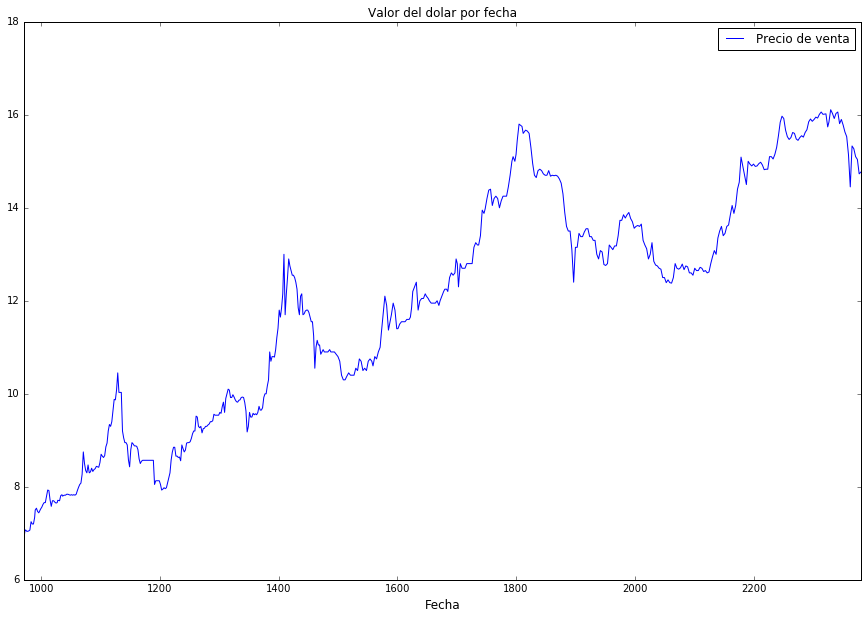

In [170]:
%matplotlib inline
ax = dolar_inf[['Precio de venta','Fecha']].plot(kind='line', title = 'Valor del dolar por fecha', figsize=(15,10))
ax.set_xlabel("Fecha",fontsize=12)
plt.show()